# Basic Baseline with 

- DINO (ViT Tiny) as image tower
- Electra Small as text tower
- Classic CLIP loss for multimodal finetuning
- Flickr30k

In [2]:
import os, sys, random
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path

from functools import partial
import itertools
from tqdm.autonotebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import ElectraTokenizerFast, ElectraConfig, ElectraForMaskedLM, ElectraForPreTraining
from torchvision.datasets import Flickr30k
from torchvision import transforms 
from hugdatafast import datasets
from hugdatafast.fastai import HF_Datasets
from fastai.text.all import *
from timm.models.layers import PatchEmbed
from timm.models.vision_transformer import VisionTransformer, _cfg

from utils import ELECTRADataProcessor

import wandb
from fastai.callback.wandb import WandbCallback


/tmp/ipykernel_9577/2101026369.py:9: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
torch.cuda.is_available()

True

### Data Exploration

In [4]:
flickr_data = Flickr30k(root="./flickr30k-images", ann_file="./flickr30k/results_20130124.token")
flickr_data.__len__

<bound method Flickr30k.__len__ of Dataset Flickr30k
    Number of datapoints: 31783
    Root location: ./flickr30k-images>

In [5]:
def flatten_dict_values(dictionary):
    return itertools.chain.from_iterable(dictionary.values())

In [6]:
flickr_data.__getitem__(123)[1]

['Someone is standing on a long bridge with a cloudy blue sky in the background .',
 'A solitary man stand on a bridge in the evening .',
 'One person is standing on a bridge at night .',
 'Person crossing a bridge in dim light .',
 'A man stands on a bridge at night .']

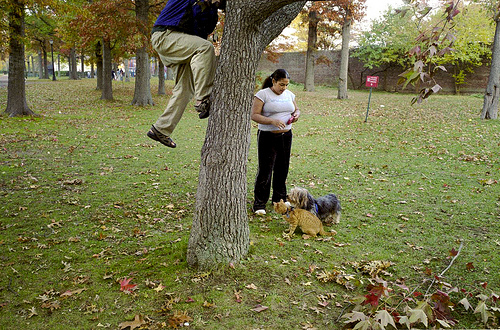

- Fat man climbs a tree , but his fat girl friend and dumb dogs wearing sweaters are not impressed .
- A large man attempts to climb a tree while a cat & dog sit near him .
- A person wearing a blue shirt and khaki pants climbing in a tree .
- A man climbing a tree while a woman is below with her dogs .
- A woman with two dogs standing near a man climbing a tree .


In [7]:
n = np.random.randint(31783)
display(flickr_data.__getitem__(n)[0])
for caption in flickr_data.__getitem__(n)[1]:
    print('-',caption)


To find mean and std, don't rerun, take too long

In [9]:
# r_channel_sum = 0
# g_channel_sum = 0
# b_channel_sum = 0
# count = 0
# for filename in os.listdir(filepath_img):
#     if filename[-3:] == 'jpg':
#         img = np.array(Image.open(os.path.join(filepath_img, filename)).convert('RGB'))
#         r_channel_sum += np.sum(img[:,:,0])
#         g_channel_sum += np.sum(img[:,:,1])
#         b_channel_sum += np.sum(img[:,:,2])
#         count += img.shape[0] * img.shape[1]
# print(r_channel_sum/count)
# print(g_channel_sum/count)
# print(b_channel_sum/count)

In [10]:
# print((r_channel_sum/count)/255)
# print((g_channel_sum/count)/255)
# print((b_channel_sum/count)/255)

Mean : (113.2971859326401, 107.42922106881713, 98.14465223794616) -> (0.444, 0.421, 0.385)

In [11]:
# r_channel_sum = 0
# g_channel_sum = 0
# b_channel_sum = 0
# count = 0
# filepath = 'flickr30k-images'
# for filename in os.listdir(filepath):
#     if filename[-3:] == 'jpg':
#         img = np.array(Image.open(os.path.join(filepath, filename)).convert('RGB'))
#         r_channel_sum += np.sum(np.square(img[:,:,0] - 113.2971859326401))
#         g_channel_sum += np.sum(np.square(img[:,:,1] - 107.42922106881713))
#         b_channel_sum += np.sum(np.square(img[:,:,2] - 98.14465223794616))
#         count += img.shape[0] * img.shape[1]
# print(np.sqrt(r_channel_sum/count))
# print(np.sqrt(g_channel_sum/count))
# print(np.sqrt(b_channel_sum/count))       

Standard Deviation : (72.70319478374329, 70.71527787982022, 72.88658377627682) -> (0.285, 0.277, 0.286)

In [12]:
# DataLoader parameter


transform = transforms.Compose([
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(), 
            transforms.ToTensor(), 
            transforms.Normalize((0.444, 0.421, 0.385), 
                                 (0.285, 0.277, 0.286))])

Build the models now, to check what specificities needed for the vocab -> classic Dataloader or not?

# ViT Tiny (following DINO)

## Pretraining DINO using only the images

In [14]:
class VisionTransformerMoCo(VisionTransformer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # Use fixed 2D sin-cos position embedding
        self.build_2d_sincos_position_embedding()

        # weight initialization
        for name, m in self.named_modules():
            if isinstance(m, nn.Linear):
                if "qkv" in name:
                    # treat the weights of Q, K, V separately
                    val = math.sqrt(6.0 / float(m.weight.shape[0] // 3 + m.weight.shape[1]))
                    nn.init.uniform_(m.weight, -val, val)
                else:
                    nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
        nn.init.normal_(self.cls_token, std=1e-6)

        if isinstance(self.patch_embed, PatchEmbed):
            # xavier_uniform initialization
            val = math.sqrt(
                6.0 / float(3 * reduce(mul, self.patch_embed.patch_size, 1) + self.embed_dim)
            )
            nn.init.uniform_(self.patch_embed.proj.weight, -val, val)
            nn.init.zeros_(self.patch_embed.proj.bias)

    def build_2d_sincos_position_embedding(self, temperature=10000.0):
        h, w = self.patch_embed.grid_size
        grid_w = torch.arange(w, dtype=torch.float32)
        grid_h = torch.arange(h, dtype=torch.float32)
        # https://pytorch.org/docs/stable/generated/torch.meshgrid.html
        # indexing –
        # (str, optional): the indexing mode, either “xy” or “ij”, defaults to “ij”.
        # If “xy” is selected, the first dimension corresponds to the cardinality of
        # the second input and the second dimension corresponds to the cardinality of the first input.
        # If “ij” is selected, the dimensions are in the same order as the cardinality of the inputs.
        grid_w, grid_h = torch.meshgrid(grid_w, grid_h, indexing="ij")
        assert (
            self.embed_dim % 4 == 0
        ), "Embed dimension must be divisible by 4 for 2D sin-cos position embedding"
        pos_dim = self.embed_dim // 4
        omega = torch.arange(pos_dim, dtype=torch.float32) / pos_dim
        omega = 1.0 / (temperature**omega)
        out_w = torch.einsum("m,d->md", [grid_w.flatten(), omega])
        out_h = torch.einsum("m,d->md", [grid_h.flatten(), omega])
        pos_emb = torch.cat(
            [torch.sin(out_w), torch.cos(out_w), torch.sin(out_h), torch.cos(out_h)], dim=1
        )[None, :, :]

        assert self.num_prefix_tokens == 1, "Assuming one and only one token, [cls]"
        pe_token = torch.zeros([1, 1, self.embed_dim], dtype=torch.float32)
        self.pos_embed = nn.Parameter(torch.cat([pe_token, pos_emb], dim=1))
        self.pos_embed.requires_grad = False


In [15]:
def vit_tiny(**kwargs):
    # patch_size is 16 by default
    model = VisionTransformerMoCo(
        embed_dim=192,
        depth=12,
        num_heads=12,
        mlp_ratio=4,
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        num_classes=0,
        **kwargs,
    )
    model.default_cfg = _cfg()
    return model


# Electra Model

## Pretraining Electra Model using only the caption

In [68]:
class CFG:
    debug = False
    image_path = "./flickr30k-images"
    captions_path = "./flickr30k/results_20130124.token"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    base_name = "vanilla"
    seed = 2022

    adam_bias_correction = False
    size = "small"

    logger = "wandb"

    datas = ["flickr30k"]
    num_workers = 3

 

In [70]:
# Check and defaults
i = ['small', 'base', 'large'].index(CFG.size)
CFG.mask_prob = [0.15, 0.15, 0.25][i]
CFG.lr = [5e-4, 2e-4, 2e-4][i]
CFG.bs = [128, 256, 2048][i]
CFG.steps = [10**6, 766*1000, 400*1000][i]
CFG.max_length = [128, 512, 512][i]
generator_size_divisor = [4, 3, 4][i]
disc_config = ElectraConfig.from_pretrained(f'google/electra-{CFG.size}-discriminator')
gen_config = ElectraConfig.from_pretrained(f'google/electra-{CFG.size}-generator')
# note that public electra-small model is actually small++ and don't scale down generator size 
gen_config.hidden_size = int(disc_config.hidden_size/generator_size_divisor)
gen_config.num_attention_heads = disc_config.num_attention_heads//generator_size_divisor
gen_config.intermediate_size = disc_config.intermediate_size//generator_size_divisor
hf_tokenizer = ElectraTokenizerFast.from_pretrained(f"google/electra-{CFG.size}-generator")

# logger
  

# Path to data
Path(CFG.image_path, exist_ok=True)
Path(CFG.captions_path,exist_ok=True)
Path('./checkpoints/pretrain').mkdir(exist_ok=True, parents=True)
edl_cache_dir = Path("./datasets/electra_dataloader")
edl_cache_dir.mkdir(exist_ok=True)

# Print info
print(f"process id: {os.getpid()}")
vars(CFG)


process id: 13531


mappingproxy({'__module__': '__main__',
              'debug': False,
              'image_path': './flickr30k-images',
              'captions_path': './flickr30k/results_20130124.token',
              'device': device(type='cuda'),
              'base_name': 'vanilla',
              'seed': 2022,
              'adam_bias_correction': False,
              'size': 'small',
              'logger': 'wandb',
              'datas': ['flickr30k'],
              'num_workers': 3,
              '__dict__': <attribute '__dict__' of 'CFG' objects>,
              '__weakref__': <attribute '__weakref__' of 'CFG' objects>,
              '__doc__': None,
              'mask_prob': 0.15,
              'lr': 0.0005,
              'bs': 128,
              'steps': 1000000,
              'max_length': 128})

### Load Data

In [117]:
ELECTRAProcessor = partial(ELECTRADataProcessor, hf_tokenizer=hf_tokenizer, max_length=CFG.max_length)

flickr = datasets.load_dataset("text",data_dir="./datasets")

e_flickr = ELECTRAProcessor(flickr)

hf_dset = HF_Datasets(e_flickr,cols={"input_ids":TensorText,"sentA_length":noop},hf_toker=hf_tokenizer,n_inp=2)

dls = hf_dset.dataloaders(bs=CFG.bs,num_workers=CFG.num_workers,pin_memory=False,
                            shuffle_train=True,srtkey_fc=False,
                            cache_dir="./datasets/electra_dataloarder",
                            cache_name="dl_{split}.json")

Using custom data configuration default-43d229bd4b94bdd7
Found cached dataset text (/home/vincent/.cache/huggingface/datasets/text/default-43d229bd4b94bdd7/0.0.0/21a506d1b2b34316b1e82d0bd79066905d846e5d7e619823c0dd338d6f1fa6ad)
100%|██████████| 1/1 [00:00<00:00, 894.69it/s]


AttributeError: 'ELECTRADataProcessor' object has no attribute 'items'

In [116]:
ELECTRAProcessor = partial(ELECTRADataProcessor, hf_tokenizer=hf_tokenizer, max_length=CFG.max_length)

flickr = datasets.load_dataset("text",data_dir="./datasets",cache_dir='./datasets')

e_flickr = ELECTRAProcessor(flickr).map(cache_file_name=f"electra_owt_{CFG.max_length}.arrow",num_proc=1)

hf_dset = HF_Datasets(e_flickr,cols={"input_ids":TensorText,"sentA_length":noop},hf_toker=hf_tokenizer,n_inp=2)

dls = hf_dset.dataloaders(bs=CFG.bs,num_workers=CFG.num_workers,pin_memory=False,
                            shuffle_train=True,srtkey_fc=False,
                            cache_dir="./datasets/electra_dataloarder",
                            cache_name="dl_{split}.json")

Using custom data configuration default-6213afefa72472b6


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1258.42it/s]


ValueError: Please pass `features` or at least one example when writing data